# Ames Modeling

Load the dataset, begin modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from itertools import combinations


In [2]:
#housing_nick = pd.read_csv('data/NH_DF.csv')
#housing_cats = pd.read_csv('data/housing_with_cats.csv')
housing = pd.read_csv('data/housing_numerical.csv')

housing.drop('latitude',axis=1,inplace=True)
housing.drop('longitude',axis=1,inplace=True)
housing.drop('DateSold',axis=1,inplace=True)

#housing.count()
#housing.info()
#housing.describe()


In [3]:
# Fill NaN with 'None' for categorical columns, and fill NaN with 0 for numerical features.
housing_na = housing.copy()
# Loop through each feature and examine
for i, feature in enumerate(housing.columns):
    if housing[feature].dtype=='object':
        housing[feature]=housing[feature].fillna('None')
    else:
        h_mean = housing[feature].mean()
        housing[feature] = housing[feature].fillna(h_mean)


# Simple Linear Regression (SLR)

In [4]:
def SLR(X, y):
    #Set up the model
    lm = LinearRegression()
    lm.fit(X, y)
    score=lm.score(X, y)
    return score


# Multiple Linear Regression (MLR)

In [5]:
def MLR(X, y):
    # Split the dataset into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% test
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test) # Make predictions on the test set
    r2_value_calculated = r2_score(y_test, y_pred)
    coef = lm.coef_
    return [r2_value_calculated, coef]


# Multiple Linear Regression (MLR) with k-fold CV

In [6]:
def MLR_kfold(X,y,k):
    # Create an instance of KFold with the desired number of folds
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Initialize lists to store RMSE and R-squared values for each fold
    mae_scores = []
    mse_scores = []
    rmse_scores = []
    r2_scores = []
    
    # Iterate over the folds
    i=0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # 2. Modeling (MLR)
        lm = LinearRegression()
        lm.fit(X_train, y_train)
        y_pred = lm.predict(X_test) # Make predictions on the test set
        
        # 3. Evaluation Calculate MAE, MSE, and RMSE for this fold
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        # Append the scores to the respective lists
        mae_scores.append(mae)
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        print(i,"R-squared:", r2)
        i=i+1

    return [rmse_scores, r2_scores]


# Penalized Regression with k-fold CV

In [47]:
# These functions do penalized regression on ridge, lasso, and elastic net
# regression models with k-fold cross validation, and uses GridSearchCV to 
# determine the best alpha

def grid_alpha(X,y,model):
    # Do GridSearchCV to find best alpha
    params = {'alpha': np.linspace(0, 1, 5)}
    grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', return_train_score=True)
    gX_train, gX_test, gy_train, gy_test = train_test_split(X, y, test_size=0.2, random_state=42)

    gX_train = StandardScaler().fit_transform(gX_train)
    gX_train = pd.DataFrame(gX_train)
    
    grid.fit(gX_train, gy_train)
    best_alpha = grid.best_params_['alpha']
    print("best alpha for ",model,": ",best_alpha)
    return best_alpha
    
def penalized(X,y,k,ratio):
    print("Ridge, Lasso, and Elastic Net with GridSearchCV for alpha")
    print("Features:\n", list(X.columns.values))

    ridge_alpha = grid_alpha(X,y, Ridge())
    lasso_alpha = grid_alpha(X,y, Lasso())
    enet_alpha = grid_alpha(X,y, ElasticNet())

    ridge_r2 = []
    lasso_r2 = []
    elasticnet_r2 = []
       
    # Create an instance of KFold with the desired number of folds, iterate
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        scaler = StandardScaler().fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_train_s = pd.DataFrame(X_train_s)

        ############################ Create Models ###########################################     
        ridge_model = Ridge(alpha=ridge_alpha) 
        lasso_model = Lasso(alpha=lasso_alpha)
        elasticnet_model = ElasticNet(alpha=enet_alpha, l1_ratio=ratio) # Ratio mixing parameter controls balance between Ridge and Lasso
    
        # Fit the models on the training data
        ridge_model.fit(X_train_s, y_train)
        lasso_model.fit(X_train_s, y_train)
        elasticnet_model.fit(X_train_s, y_train)
    
        ######################### Make predictions using models #############################
        X_test_s = scaler.transform(X_test)
        X_test_s = pd.DataFrame(X_test_s)
        ridge_predictions = ridge_model.predict(X_test_s)
        lasso_predictions = lasso_model.predict(X_test_s)
        elasticnet_predictions = elasticnet_model.predict(X_test_s)
    
        ############################ Evaluate Models #########################################
        # Calculate R-squared for the models
        ridge_r2.append(r2_score(y_test, ridge_predictions))
        lasso_r2.append(r2_score(y_test, lasso_predictions))
        elasticnet_r2.append(r2_score(y_test, elasticnet_predictions))
    
    print("R-squared for Ridge model:", np.mean(ridge_r2))
    print("R-squared for Lasso model:", np.mean(lasso_r2))
    print("R-squared for ElasticNet model:", np.mean(elasticnet_r2))
    

# Running the models

## Running Simple Linear Regression

In [8]:
# Run SLR for all of the variables (non-nominal)

#remove categorical non numeric features
housing_num = housing.select_dtypes(exclude=[object])
features = list(housing_num.columns.values)

results = []
# Loop through each feature and examine the score
for i, feature in enumerate(housing[features]):
    X=housing[[features[i]]]
    y=housing['SalePrice']
    score=SLR(X,y)
    results.append([score,feature])

results.sort(reverse=True)
print("R2 for the top 10 Simple Linear Regression models: \nscore, feature\n", results[:10])

R2 for the top 10 Simple Linear Regression models: 
score, feature
 [[1.0, 'SalePrice'], [0.6798715958383224, 'TotalSF'], [0.6298616937506346, 'OverallQual'], [0.5204328184549516, 'GrLivArea'], [0.46774549979837465, 'ExterQual'], [0.43177063751011224, 'KitchenQual'], [0.4283448377541429, 'TotalBsmtSF'], [0.4154510111295472, 'BsmtQual'], [0.4154213603034195, '1stFlrSF'], [0.4120791972028769, 'GarageCars']]


## Running Multiple Linear Regression

In [9]:
best15_features = ['GrLivArea', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 
            'Age', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
            'LowQualFinSF', 'BedroomAbvGr'] #top 15 from one of the combinatorics run
X = housing[best15_features]  # Features
y = housing['SalePrice']  # Target variable

r = MLR(X,y)
print(best15_features)
print("R2 for Multiple Linear Regression model: ", r[0])
print("Coefficient:", r[1])

['GrLivArea', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'Age', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF', 'BedroomAbvGr']
R2 for Multiple Linear Regression model:  0.8649311612533718
Coefficient: [ 6.83147292e+01 -9.36749703e+02  2.82851291e+01  7.10371974e-01
  1.57501567e+04  4.90140681e+03 -3.30065923e+02  2.13539994e+02
  3.76511543e+01  2.11208137e+01  1.13389184e+01 -3.25206899e+00
  2.92076632e+01 -1.76731942e+01 -9.61122618e+03]


In [10]:
# Run MLR with K-fold CV

# MLR with K-fold Cross Validation
features = ['TotalSF','Age']
X = housing[features]  # Features
y = housing['SalePrice']  # Target variable

print("MLR with k-fold Cross Validation")
print("Features:\n", features)

r = MLR_kfold(X,y,k=5)

#print("Average RMSE:", avg_rmse)
print("Average R-squared:", np.mean(r[1]))
print("Standard deviation of R-squared:", np.std(r[1]))


MLR with k-fold Cross Validation
Features:
 ['TotalSF', 'Age']
0 R-squared: 0.748909898301216
1 R-squared: 0.759749861919766
2 R-squared: 0.7618708846412267
3 R-squared: 0.754905357875141
4 R-squared: 0.7065066069288354
Average R-squared: 0.7463885219332369
Standard deviation of R-squared: 0.020433746298346732


## Running Ridge, Lasso, and Elastic Net

In [48]:
X = housing[best15_features]  # Features
y = housing['SalePrice']  # Target variable

penalized(X,y,k=5,ratio=0.5)

Ridge, Lasso, and Elastic Net with GridSearchCV for alpha
Features:
 ['GrLivArea', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'Age', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF', 'BedroomAbvGr']
best alpha for  Ridge() :  1.0
best alpha for  Lasso() :  1.0
best alpha for  ElasticNet() :  0.0
R-squared for Ridge model: 0.8645186098594705
R-squared for Lasso model: 0.8645159001062597
R-squared for ElasticNet model: 0.8645154362807087


## Running categorical features

In [12]:

#features = ['TotalSF','Age']
#features = ['TotalSF','OverallQual']
features = ['TotalSF','Neighborhood']
X = housing[features]  # Features

# Convert categorical columns to one-hot encoding
X = pd.get_dummies(X, columns=['Neighborhood'], drop_first=True)
y = housing['SalePrice']  # Target variable

r = MLR(X,y)
print(features)
print("R2 for Multiple Linear Regression model: ", r[0])
print("Coefficient:", r[1])

['TotalSF', 'Neighborhood']
R2 for Multiple Linear Regression model:  0.7912020836411895
Coefficient: [5.96965002e+01 1.80183691e+04 2.46125247e+03 6.10022937e+03
 3.09357870e+04 4.39267752e+04 3.20400792e+04 1.13479667e+05
 1.77133054e+04 5.17372451e+04 3.94660442e+04 7.77843590e+03
 1.60107170e+04 5.07121232e+04 6.80960598e+04 7.65711865e+04
 1.69979413e+04 1.02166957e+05 2.11279580e+04 5.09140860e+04
 6.80456047e+04 4.86559995e+04 1.63450113e+05 1.11956439e+05
 6.42902050e+04 2.26043553e+04 4.25261425e+04 3.13489049e+04]


##  Multiple Linear Regression using Combinatorics for Feature Selection

In [110]:
# Run MLR for all combinations of features to determine the best combi

#remove categorical non numeric features
housing_num = housing.select_dtypes(exclude=[object])
features = list(housing_num.columns.values)
features.remove('SalePrice')
feature_list = features.copy()
print("Total features:",len(features))

mutual_best = ['TotalSF', 'OverallQual', 'GrLivArea', 'ExterQual', 'GarageCars', 
               'Age','KitchenQual','GarageArea','BsmtFinSF1','1stFlrSF','BsmtQual',
               'LotArea','MasVnrArea','YearRemodAdd','Neighborhood']
features_unkwn = [ elem for elem in features if elem not in mutual_best]
print(len(features_unkwn), "uncertain features")

# Get all R2s of models with one fewer feature, find the best R2, remove lowest feature, repeat
while len(features_unkwn)>1:
    print("Looking at using ",len(features_unkwn)-1, " of these features")
    comb = combinations(features_unkwn, len(features_unkwn)-1)
    results = {}
    #Get all r2 of all combinations of one fewer features
    for c in comb:
        mutual_best_plus = mutual_best.copy()
        mutual_best_plus.extend(c)
        X = housing[mutual_best_plus]  # Features
        y = housing['SalePrice']  # Target variable
        r = MLR(X, y)
        results[r[0]] = mutual_best_plus

    #Sort list of r2s, find best r2, find feature that was not included, drop that feature
    r2s = list(results.keys())
    r2s.sort()
    best_features = results[r2s[0]]
    feature_to_drop = [ elem for elem in feature_list if elem not in best_features]
    print("R2:",r2s[0],"Feature found to drop",feature_to_drop)
    features_unkwn.remove(feature_to_drop[0])
    feature_list.remove(feature_to_drop[0])
print("Last remaining feature",feature_list)    

Total features: 81
66 uncertain features
Looking at using  65  of these features
R2: 0.8844795924879507 Feature found to drop ['BldgType']
Looking at using  64  of these features
R2: 0.8812016615325675 Feature found to drop ['OverallCond']
Looking at using  63  of these features
R2: 0.8772305234981039 Feature found to drop ['Functional']
Looking at using  62  of these features
R2: 0.875224671058177 Feature found to drop ['ScreenPorch']
Looking at using  61  of these features
R2: 0.873164446142345 Feature found to drop ['MSZoning']
Looking at using  60  of these features
R2: 0.8711313542959633 Feature found to drop ['KitchenAbvGr']
Looking at using  59  of these features
R2: 0.8703694224502999 Feature found to drop ['Bath']
Looking at using  58  of these features
R2: 0.8696120501704416 Feature found to drop ['Exterior1st']
Looking at using  57  of these features
R2: 0.8689255795639927 Feature found to drop ['MSSubClass']
Looking at using  56  of these features
R2: 0.8675336145530899 Fea

# LazyPredict Results

  5%|██                                          | 2/42 [00:00<00:06,  6.54it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8221848784876566, 'Adjusted R-Squared': 0.8168504248422863, 'RMSE': 31108.16551917727, 'Time taken': 0.18518948554992676}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8838160473707461, 'Adjusted R-Squared': 0.8803305287918686, 'RMSE': 25145.665222492247, 'Time taken': 0.12959003448486328}
{'Model': 'BayesianRidge', 'R-Squared': 0.8648424226588634, 'Adjusted R-Squared': 0.8607876953386293, 'RMSE': 27121.2845291356, 'Time taken': 0.009819269180297852}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7751534888595866, 'Adjusted R-Squared': 0.7684080935253742, 'RMSE': 34981.07343739264, 'Time taken': 0.02620530128479004}
{'Model': 'DummyRegressor', 'R-Squared': -4.298010936176766e-05, 'Adjusted R-Squared': -0.030044269512642607, 'RMSE': 73773.33020994296, 'Time taken': 0.007416486740112305}
{'Model': 'ElasticNet', 'R-Squared': 0.8273110541205199, 'Adjusted R-Squared': 0.8221303857441354, 'RMSE': 30656.482648203473, 'Time taken': 0.006495237350

 17%|███████▎                                    | 7/42 [00:00<00:01, 20.70it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.08644121052193654, 'Adjusted R-Squared': 0.05903444683759462, 'RMSE': 70511.23247140569, 'Time taken': 0.06639480590820312}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7898625743023164, 'Adjusted R-Squared': 0.7835584515313859, 'RMSE': 33817.52030214012, 'Time taken': 0.015068292617797852}


 24%|██████████▏                                | 10/42 [00:00<00:03,  9.70it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8952214573763881, 'Adjusted R-Squared': 0.8920781010976798, 'RMSE': 23879.555165083184, 'Time taken': 0.5223038196563721}
{'Model': 'GammaRegressor', 'R-Squared': 0.8062279375565906, 'Adjusted R-Squared': 0.8004147756832883, 'RMSE': 32473.988796096757, 'Time taken': 0.0087890625}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.3295026863126371, 'Adjusted R-Squared': -0.36938776690201625, 'RMSE': 85061.81891926589, 'Time taken': 0.25026488304138184}


 29%|████████████▎                              | 12/42 [00:01<00:04,  6.16it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9176864307700451, 'Adjusted R-Squared': 0.9152170236931464, 'RMSE': 21165.365493490768, 'Time taken': 0.37661218643188477}


 38%|████████████████▍                          | 16/42 [00:02<00:03,  7.43it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9146020290572757, 'Adjusted R-Squared': 0.912040089928994, 'RMSE': 21558.266266883504, 'Time taken': 0.2550692558288574}
{'Model': 'HuberRegressor', 'R-Squared': 0.856578411031305, 'Adjusted R-Squared': 0.8522757633622442, 'RMSE': 27938.12914079551, 'Time taken': 0.024946928024291992}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.855972635890937, 'Adjusted R-Squared': 0.8516518149676651, 'RMSE': 27997.068631687885, 'Time taken': 0.03539323806762695}
{'Model': 'KernelRidge', 'R-Squared': -4.939760736564059, 'Adjusted R-Squared': -5.1179535586609815, 'RMSE': 179793.7253871519, 'Time taken': 0.12874531745910645}
{'Model': 'Lars', 'R-Squared': 0.8649311612533728, 'Adjusted R-Squared': 0.860879096090974, 'RMSE': 27112.37973858692, 'Time taken': 0.011650800704956055}


 48%|████████████████████▍                      | 20/42 [00:02<00:01, 11.77it/s]

{'Model': 'LarsCV', 'R-Squared': 0.8646562498030567, 'Adjusted R-Squared': 0.8605959372971483, 'RMSE': 27139.95721296858, 'Time taken': 0.021822214126586914}
{'Model': 'Lasso', 'R-Squared': 0.864930659918806, 'Adjusted R-Squared': 0.8608785797163702, 'RMSE': 27112.43005500581, 'Time taken': 0.008947372436523438}
{'Model': 'LassoCV', 'R-Squared': 0.8644181724971434, 'Adjusted R-Squared': 0.8603507176720577, 'RMSE': 27163.817084176084, 'Time taken': 0.056923627853393555}
{'Model': 'LassoLars', 'R-Squared': 0.8649299132111413, 'Adjusted R-Squared': 0.8608778106074756, 'RMSE': 27112.504998110362, 'Time taken': 0.009407758712768555}
{'Model': 'LassoLarsCV', 'R-Squared': 0.8646562498030567, 'Adjusted R-Squared': 0.8605959372971483, 'RMSE': 27139.95721296858, 'Time taken': 0.02451181411743164}
{'Model': 'LassoLarsIC', 'R-Squared': 0.8649311612533728, 'Adjusted R-Squared': 0.860879096090974, 'RMSE': 27112.37973858692, 'Time taken': 0.013366937637329102}
{'Model': 'LinearRegression', 'R-Squared

 67%|████████████████████████████▋              | 28/42 [00:03<00:01,  9.61it/s]

{'Model': 'MLPRegressor', 'R-Squared': -5.616165801876334, 'Adjusted R-Squared': -5.814650775932624, 'RMSE': 189755.00761236297, 'Time taken': 0.757174015045166}
{'Model': 'NuSVR', 'R-Squared': -0.010879873690596398, 'Adjusted R-Squared': -0.04120626990131426, 'RMSE': 74171.97283873353, 'Time taken': 0.14419770240783691}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.6060347232801243, 'Adjusted R-Squared': 0.594215764978528, 'RMSE': 46304.055338959646, 'Time taken': 0.006205558776855469}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8299457522370165, 'Adjusted R-Squared': 0.8248441248041269, 'RMSE': 30421.72232045697, 'Time taken': 0.011358261108398438}


 79%|█████████████████████████████████▊         | 33/42 [00:03<00:00, 13.65it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8541489325664607, 'Adjusted R-Squared': 0.8497734005434545, 'RMSE': 28173.76329993604, 'Time taken': 0.04784083366394043}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9127143685797549, 'Adjusted R-Squared': 0.9100957996371475, 'RMSE': 21795.228905986074, 'Time taken': 0.012914419174194336}
QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.
{'Model': 'RANSACRegressor', 'R-Squared': 0.8407023547452894, 'Adjusted R-Squared': 0.8359234253876481, 'RMSE': 29443.85929431575, 'Time taken': 0.06146597862243652}


 86%|████████████████████████████████████▊      | 36/42 [00:04<00:00,  6.52it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8950705334588199, 'Adjusted R-Squared': 0.8919226494625845, 'RMSE': 23896.747135176443, 'Time taken': 1.1386981010437012}
{'Model': 'Ridge', 'R-Squared': 0.8649135069063798, 'Adjusted R-Squared': 0.8608609121135712, 'RMSE': 27114.151559994767, 'Time taken': 0.00685572624206543}
{'Model': 'RidgeCV', 'R-Squared': 0.8647442248640107, 'Adjusted R-Squared': 0.860686551609931, 'RMSE': 27131.135130266804, 'Time taken': 0.007007598876953125}
{'Model': 'SGDRegressor', 'R-Squared': 0.8658374834723963, 'Adjusted R-Squared': 0.8618126079765682, 'RMSE': 27021.26356330245, 'Time taken': 0.014986753463745117}


 98%|█████████████████████████████████████████▉ | 41/42 [00:04<00:00,  8.41it/s]

{'Model': 'SVR', 'R-Squared': -0.05935824312909177, 'Adjusted R-Squared': -0.09113899042296447, 'RMSE': 75929.66447285078, 'Time taken': 0.19846320152282715}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.8651892474643518, 'Adjusted R-Squared': 0.8611449248882823, 'RMSE': 27086.46451934868, 'Time taken': 0.008935928344726562}
{'Model': 'TweedieRegressor', 'R-Squared': 0.7866930984251913, 'Adjusted R-Squared': 0.780293891377947, 'RMSE': 34071.59849416968, 'Time taken': 0.010888338088989258}
{'Model': 'XGBRegressor', 'R-Squared': 0.9120290735103294, 'Adjusted R-Squared': 0.9093899457156392, 'RMSE': 21880.62074291825, 'Time taken': 0.1554415225982666}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1983
[LightGBM] [Info] Number of data points in the train set: 2061, number of used features: 15
[LightGBM] [Info] Start training from score 177

100%|███████████████████████████████████████████| 42/42 [00:04<00:00,  8.57it/s]


{'Model': 'LGBMRegressor', 'R-Squared': 0.9135665320106376, 'Adjusted R-Squared': 0.9109735279709568, 'RMSE': 21688.575317407227, 'Time taken': 0.08685970306396484}


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33],
 [Text(0, 0, 'GradientBoostingRegressor'),
  Text(1, 0, 'HistGradientBoostingRegressor'),
  Text(2, 0, 'LGBMRegressor'),
  Text(3, 0, 'PoissonRegressor'),
  Text(4, 0, 'XGBRegressor'),
  Text(5, 0, 'ExtraTreesRegressor'),
  Text(6, 0, 'RandomForestRegressor'),
  Text(7, 0, 'BaggingRegressor'),
  Text(8, 0, 'SGDRegressor'),
  Text(9, 0, 'TransformedTargetRegressor'),
  Text(10, 0, 'LinearRegression'),
  Text(11, 0, 'Lars'),
  Text(12, 0, 'LassoLarsIC'),
  Text(13, 0, 'Lasso'),
  Text(14, 0, 'LassoLars'),
  Text(15, 0, 'Ridge'),
  Text(16, 0, 'BayesianRidge'),
  Text(17, 0, 'RidgeCV'),
  Text(18, 0, 'LarsCV'),
  Text(19, 0, 'LassoLarsCV'),
  Text(20, 0, 'LassoCV'),
  Text(21, 0, 'HuberRegressor'),
  Text(22, 0, 'KNeighborsRegressor'),
  Text(23, 0, 'PassiveAggressiveRegressor'),
  Text(24, 0, 'RA

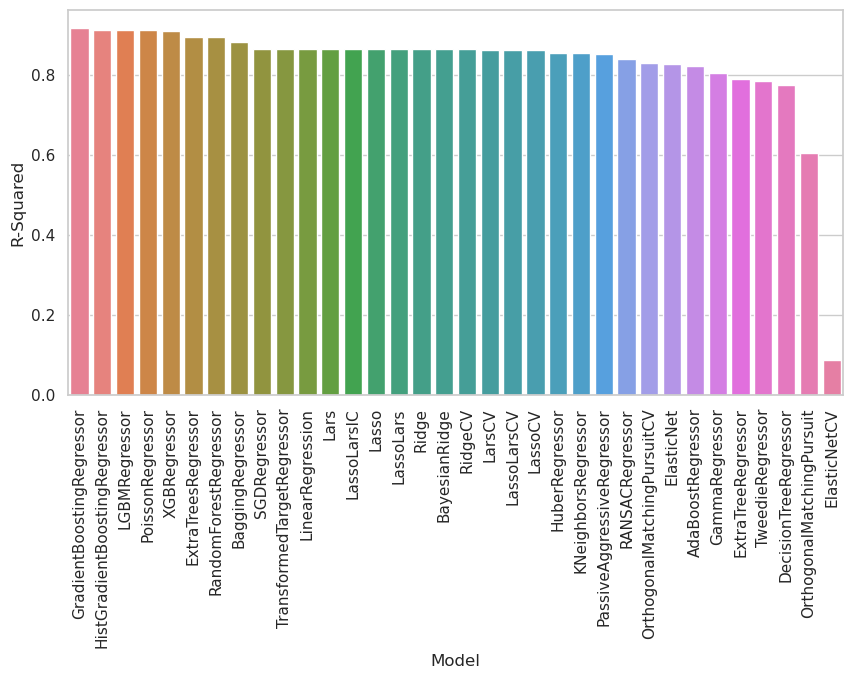

In [58]:
from lazypredict.Supervised import LazyRegressor

features = ['GrLivArea', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 
            'Age', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
            'LowQualFinSF', 'BedroomAbvGr']
X = housing[features]  # Features
y = housing['SalePrice']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% test

reg = LazyRegressor(verbose=1, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

models=models[models['R-Squared']>0]

plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=models.index, y='R-Squared', data=models, palette="husl")
plt.xticks(rotation=90)

# RandomForestRegressor

In [13]:
X = housing.drop(['SalePrice'],axis=1) # Features
y = housing['SalePrice']  # Target variable

# Run the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
print(f'R^2 Score: {r2_score(y_test, y_pred)}\n')

# Print R^2 score for each fold
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

for i, score in enumerate(scores, 1):
    print(f"   R^2 Score for fold {i}: {score:.4f}")
print(f"Average R^2 Score across the 5 folds: {scores.mean():.4f}")


R^2 Score: 0.9093252003692234

   R^2 Score for fold 1: 0.8927
   R^2 Score for fold 2: 0.9178
   R^2 Score for fold 3: 0.8967
   R^2 Score for fold 4: 0.9080
   R^2 Score for fold 5: 0.9143
Average R^2 Score across the 5 folds: 0.9059


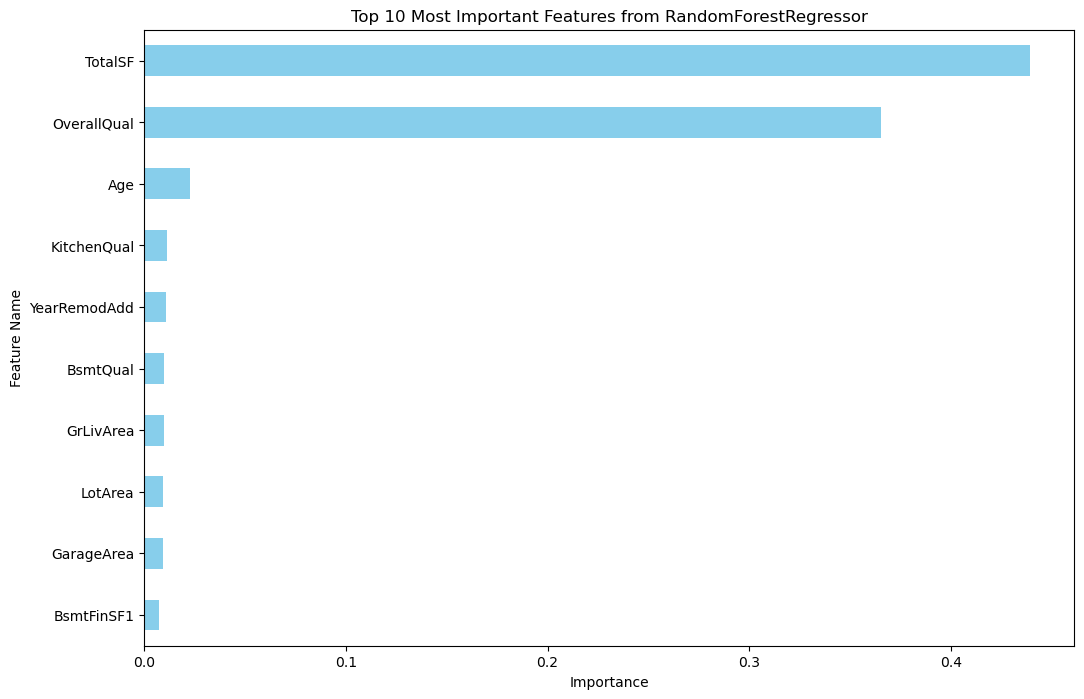

In [16]:
# Map importances to the column names
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X_train.columns)
top_10 = feature_importances.sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 8))
top_10.plot(kind='barh', color='skyblue')
plt.title('Top 10 Most Important Features from RandomForestRegressor')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.gca().invert_yaxis()  # to have the most important feature at the top
plt.show()


# XGBoost Regressor

## Default tuning

In [34]:
X = housing_na.drop('SalePrice',axis=1) # Features
y = housing_na['SalePrice'] # Target variable

# Initialize the KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over the folds
r2_scores = []
fold = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))
    
    print(f"Fold {fold}: R2 = {r2_score(y_test, y_pred):.4f}")
    fold += 1

mean_r2 = np.mean(r2_scores)
print(f"Mean R2: {mean_r2:.4f}")


Fold 1: R2 = 0.9102
Fold 2: R2 = 0.9327
Fold 3: R2 = 0.9072
Fold 4: R2 = 0.9135
Fold 5: R2 = 0.9052
Mean R2: 0.9137


## Hyperparameter tuning

In [ ]:
xgb.set_config(verbosity=2)

param_grid = {
    'learning_rate': [0.03, 0.05, 0.07, 0.1],    #default=0.3, range from [0,1], best near 0.05-0.1
    'n_estimators': [400],
    'subsample': [0.001, 0.01, 0.04, 0.06, 0.1, 0.5, 0.6, 0.7],         #default=1, range: (0,1]
    'tree_method': ['hist'],    #default='auto', hist good with reg:squarederror
    'grow_policy': ['lossguide'], #default='depthwise', lossguide splits at nodes with highest loss change
    'max_bin': [2, 5, 256, 600],             #default=256, only used with tree_method hist and approx, best larger than default 
    'gamma': [0, 0.1, 0.2, 1, 7, 15, 100],               #default=0, range: [0,inf]
    'reg_alpha': [0, 1, 4, 20, 50, 75, 100, 200, 500, 1000],           #default=0, [0,inf]
    'reg_lambda': [0, 0.5, 1, 4, 20, 50, 100],          #default=1, [0,inf]
    'min_child_weight': [0, 1, 3, 5, 20, 100],  #default=1, range [0,inf]
    'max_leaves': [0, 4, 7, 10],          #default=0, max num of nodes added
    'max_depth': [2, 4, 5, 6, 7, 9]         #default=6, range: [0,inf]
}

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X, y)
print(f"Best hyperparameters: {grid_search.best_params_}")

In [36]:
best_params = {
   'learning_rate': 0.05, #[0.03, 0.05, 0.07, 0.1]
    'n_estimators': 650,   #default reduces R2, 4000 reduces, 400 good, 600 better, 700 goes down
    'subsample': 0.5,         #[0.001, 0.01, 0.04, 0.06, 0.1, 0.5, 0.6, 0.7]
    'tree_method': 'hist',    #default='auto', hist good with reg:squarederror
    'grow_policy': 'lossguide', #default='depthwise', lossguide splits at nodes with highest loss change
    'max_bin': 600,             # [2, 5, 256, 600]
    'gamma': 0,               #[0, 0.1, 0.2, 1, 7, 15, 100]
    'reg_alpha': 100,           #[0, 1, 4, 20, 50, 75, 100, 200, 500, 1000]
    'reg_lambda': 1,          #[0, 0.5, 1, 4, 20, 50, 100]
    'min_child_weight': 5,  #[0, 1, 3, 5, 20, 100]
    'max_leaves': 0,          #[0, 4, 7, 10]
    'max_depth': 5         #[2, 4, 5, 6, 7, 9]
}

#grid_search.best_params_
model = xgb.XGBRegressor(**best_params, objective="reg:squarederror", random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=0)
mse_scores = []
r2_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse_scores.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
    

print("MSE for each fold:", mse_scores)
print("R^2 for each fold:", r2_scores)
print("Average MSE:", sum(mse_scores) / len(mse_scores))
print("Average R^2:", sum(r2_scores) / len(r2_scores))



MSE for each fold: [320461444.10797346, 235994588.26076543, 437284722.344268, 324813965.20246524, 437879740.35483813]
R^2 for each fold: [0.9479369747977182, 0.9457013662875113, 0.9296813655318784, 0.9413183456495426, 0.9158380875841782]
Average MSE: 351286892.05406207
Average R^2: 0.9360952279701659


## Feature Importance

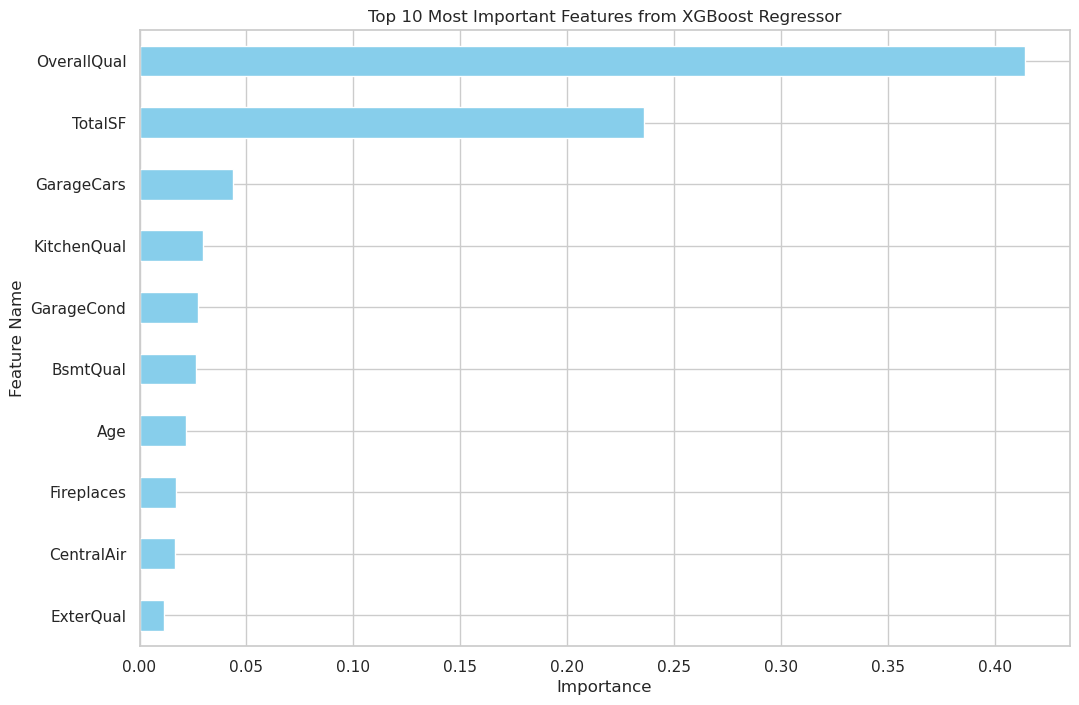

In [38]:
# Map importances to the column names
model.fit(X, y)
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X_train.columns)
top_10 = feature_importances.sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 8))
top_10.plot(kind='barh', color='skyblue')
plt.title('Top 10 Most Important Features from XGBoost Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.gca().invert_yaxis()  # to have the most important feature at the top
plt.show()


# Gradient Boosting Regressor

## First run with no tuning

In [39]:
X = housing.drop('SalePrice',axis=1) # Features
y = housing['SalePrice'] # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
# Print average R^2 score
print(f"\nAverage R^2 Score across the 5 folds: {scores.mean():.4f}")


Average R^2 Score across the 5 folds: 0.9245


## Hyperparameter tuning

In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01, 0.001],
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'subsample': [0.3, 0.7, 0.8, 0.9],   
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'min_weight_fraction_leaf': [0, 0.25, 0.5],    
    'max_depth': [3, 5, 6, 7],
    'max_leaf_nodes': [5, 10, 50]
}

X = housing.drop('SalePrice',axis=1) # Features
y = housing['SalePrice'] # Target variable

model = GradientBoostingRegressor(random_state=42, max_features=0.4)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X, y)
print(f"Best hyperparameters: {grid_search.best_params_}")


In [40]:
test_param = {
    'learning_rate': 0.008,
    'n_estimators': 7000,
    'subsample': 0.3,   
    'min_samples_split': 4,
    'min_samples_leaf': 1,   
    'max_depth': 5,
    'max_leaf_nodes': 5,
    'max_features': 0.9,
    'random_state': 42
}

best_paramGRIDresult = {
    'learning_rate': 0.011,
    'n_estimators': 4000,
    'subsample': 0.3,
    'min_samples_split': 5,
    'max_depth': 3,
    'max_features': 0.2,
    'random_state': 42
}

X = housing.drop('SalePrice',axis=1) # Features
y = housing['SalePrice'] # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(**best_paramGRIDresult)
model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print(f"\nAverage R^2 Score across the 5 folds: {scores.mean():.4f}")


Average R^2 Score across the 5 folds: 0.9407


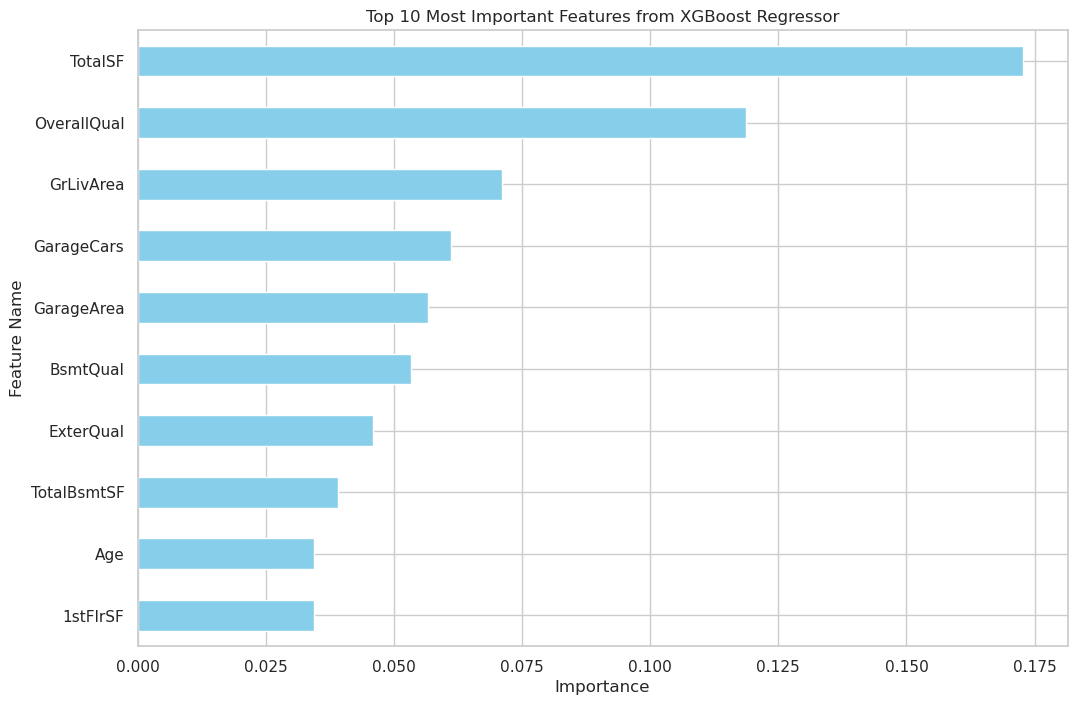

In [42]:

importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X_train.columns)
top_10 = feature_importances.sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 8))
top_10.plot(kind='barh', color='skyblue')
plt.title('Top 10 Most Important Features from XGBoost Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.gca().invert_yaxis()  # to have the most important feature at the top
plt.show()


# Modeling Overview

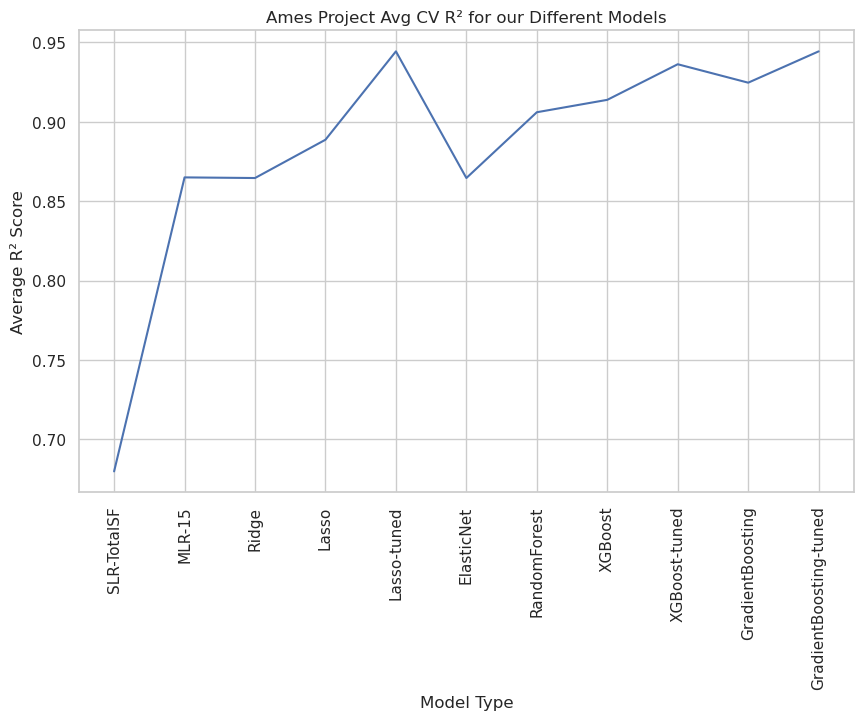

In [56]:
model_names = ['SLR-TotalSF','MLR-15','Ridge','Lasso', 'Lasso-tuned',
               'ElasticNet', 'RandomForest', 'XGBoost', 'XGBoost-tuned', 
               'GradientBoosting', 'GradientBoosting-tuned']
avg_r2_scores = [0.6799, 0.8649, 0.8645, 0.8886, 0.9442,
                 0.8645, 0.9059, 0.9137, 0.9361, 
                 0.9245, 0.9442]

# Plot average R² against the number of features
plt.figure(figsize=(10, 6))
plt.plot(model_names, avg_r2_scores)
plt.title('Ames Project Avg CV R² for our Different Models')
plt.xlabel('Model Type')
plt.ylabel('Average R² Score')
plt.xticks(rotation=90)
plt.show()